In [1]:
import __init__
from data_processing.data_splitter import DataSplitter
from datapath_manager import ITWDataPathManager, DataPathManager
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import shap
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from evaluators import Evaluator
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

/home/nmduy/anaconda3/envs/stress/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Lab experiment data
dataset_name = 'DCU_NVT_EXP2'
# dataset_name = 'WESAD_wrist'
method = 'dependent'
model_name = 'branch_neural_network'
test_size = 0.2
# user_id = 'nvtu'
# user_id = 'tlduyen'
user_id = 'lzhou'
# user_id = 'ltkhiem'
# user_id = 'ntnhu'
# user_id = 'cgurrin'
# user_id = 'nmduy'
# user_id = 'lzhou'

# In-the-wild data
itw_dataset_name = 'DCU_EXP2_ITW'
feature_names = [line.strip() for line in open('feature_names.txt', 'r').readlines()]

In [3]:
def boxplot_features(features):
    features = pd.DataFrame(features)
    features.boxplot(figsize=(20, 4))

In [4]:
def boxplot_by_features(X, Y, Z = None, T = None, labels = ['Stress', 'Relax']):
    """
    X: feature matrix
    Y: feature matrix
    X and Y should have the same number of rows
    """
    nrows, ncols = 12, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 50))

    num_features = X.shape[1]
    for i in range(num_features):
        data = [X[:, i], Y[:, i]]
        if Z is not None:
            if Z.shape[0] == 0:
                data.append([])
            else:
                data.append(Z[:, i])
        if T is not None:
            data.append(T[:, i])
        x, y = i // ncols, i % ncols
        ax[x, y].boxplot(data, labels=labels)
        ax[x, y].set_title(feature_names[i])

# USER EXPERIMENT: FEATURE ANALYSIS

In [7]:
def get_itw_signal_index(signal_type):
    if signal_type == 'eda':
        return 30, 66
    elif signal_type == 'bvp':
        return 0, 30
    elif signal_type == 'temp':
        return 66, 72
    return None

In [17]:
SIGNAL_TYPE = 'bvp'
WINDOW_SHIFT = 0.25
WINDOW_SIZE = 60
dp_manager = DataPathManager(dataset_name)

# Lab experiment data
user_feature_path = os.path.join(dp_manager.ds_path_manager.user_data_paths[user_id].feature_path, f'{WINDOW_SIZE}_{WINDOW_SHIFT}')
feature_path = os.path.join(user_feature_path, f'{SIGNAL_TYPE}.npy')
ground_truth_path = os.path.join(user_feature_path, 'ground_truth.npy')
task_indices_path = os.path.join(user_feature_path, 'tasks_index.npy')

# In-the-wild data
date = '2022-09-11'
itw_dp_manager = ITWDataPathManager(itw_dataset_name)
feature_folder_path = itw_dp_manager.get_feature_path_by_date(user_id, date)
# itw_feature_path = os.path.join(feature_folder_path, 'X_moment.npy')
itw_feature_path = os.path.join(feature_folder_path, 'bvp_eda_temp.npy')
itw_ground_truth_path = os.path.join(feature_folder_path, 'y_moment.npy')
itw_info_path = os.path.join(feature_folder_path, 'datetime_info.npy')

In [21]:
# Lab experiment data

features = np.load(feature_path)
ground_truth = np.load(ground_truth_path)
task_indices = np.load(task_indices_path)
assert(features.shape[0] == ground_truth.shape[0])

# Split train test data
train_indices = []
test_indices = []
for _, test_index in LeaveOneGroupOut().split(features, ground_truth, task_indices):
    # Fetch the task 
    _X, _y, _task = features[test_index], ground_truth[test_index], task_indices[test_index]
    # Split train/test data based on the task
    cut_point = int((1 - test_size) * len(test_index))
    train_indices += test_index[:cut_point].tolist()
    test_indices += test_index[cut_point:].tolist()

X_train, y_train, X_test, y_test = features[train_indices], ground_truth[train_indices], features[test_indices], ground_truth[test_indices]
X_trs, X_trr, X_ts, X_tr = X_train[y_train == 1], X_train[y_train == 0], X_test[y_test == 1], X_test[y_test == 0]

In [19]:
# In-the-wild data
itw_features = np.nan_to_num(np.load(itw_feature_path)[:, :30])
itw_ground_truth = np.zeros(itw_features.shape[0])
# prev_index, current_index = get_itw_signal_index(SIGNAL_TYPE)
# itw_features = np.load(itw_feature_path)[:, prev_index:current_index]
# itw_ground_truth = np.load(itw_ground_truth_path)
# itw_info = np.load(itw_info_path)
# assert(itw_features.shape[0] == itw_ground_truth.shape[0])
# print(itw_features.shape, itw_ground_truth.shape)

In [ ]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# scaled_Xtrs, scaled_X_trr, scaled_X_ts, scaled_X_tr = scaler.transform(X_trs), scaler.transform(X_trr), scaler.transform(X_ts), scaler.transform(X_tr)
# scaled_itw_features = scaler.transform(itw_features)

In [ ]:
# boxplot_by_features(X_trs, X_trr)
boxplot_by_features(X_trs, X_trr, itw_features[itw_ground_truth == 1], itw_features[itw_ground_truth == 0], labels = ['Train_S', 'Train_R', 'ITW_S', 'ITW_R'])
# boxplot_by_features(X_trs, X_trr, itw_features[itw_ground_truth == 0], labels = ['Train_S', 'Train_R', 'ITW_R'])

In [22]:
indices = [i for i in range(30) if i not in [7, 9]]
X_train = X_train[:, indices]
X_test = X_test[:, indices]

In [23]:
clf = ExtraTreesClassifier(
    n_estimators = 500,
    random_state = 0, 
    n_jobs = -1, 
    max_features = 'sqrt', 
    max_depth = 8, 
    min_samples_split = 2, 
    min_samples_leaf = 8,
    oob_score = True, 
    bootstrap = True, 
    class_weight = 'balanced'
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
Evaluator().evaluate(y_test, y_pred)
# clf = LogisticRegression(
#     random_state = 0,
#     class_weight = 'balanced',
#     n_jobs = -1,
#     solver = 'saga',
#     max_iter = 10000,
# )
# clf = KNeighborsClassifier(weights = 'distance', n_neighbors = 5)
# scaler = StandardScaler()
# scaler.fit(X_train)
# scaled_X_train = scaler.transform(X_train)
# clf.fit(scaled_X_train, y_train)
# model = SelectFromModel(clf, prefit=True)
# new_X_train = model.transform(X_train)
# new_X_test = model.transform(X_test)
# clf.fit(new_X_train, y_train)

{'accuracy': 0.8776916451335056,
 'balanced_accuracy': 0.8550847148843141,
 'precision': 0.883617963314358,
 'recall': 0.9331997327989312,
 'f1': 0.9077322936972061}

In [ ]:
clf = LogisticRegression(
    random_state = 0,
    class_weight = 'balanced',
    n_jobs = -1,
    solver = 'saga',
    max_iter = 10000,
)
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
clf.fit(scaled_X_train, y_train)
y_pred = clf.predict(scaled_X_test)
Evaluator().evaluate(y_test, y_pred)

In [24]:
itw_features = itw_features[:, indices]

y_pred contains classes not in y_true
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


{'accuracy': 0.683158723852143, 'balanced_accuracy': 0.683158723852143, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


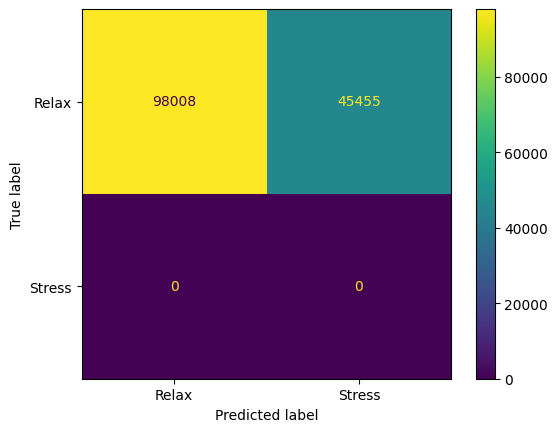

In [26]:
y_pred = clf.predict(itw_features)
print(Evaluator().evaluate(itw_ground_truth, y_pred))
ConfusionMatrixDisplay.from_predictions(itw_ground_truth, y_pred, display_labels = ['Relax', 'Stress'])

In [27]:
TP = [i for i in range(len(y_pred)) if y_pred[i] == 1 and itw_ground_truth[i] == 1]
FP = [i for i in range(len(y_pred)) if y_pred[i] == 1 and itw_ground_truth[i] == 0]
FN = [i for i in range(len(y_pred)) if y_pred[i] == 0 and itw_ground_truth[i] == 1]
TN = [i for i in range(len(y_pred)) if y_pred[i] == 0 and itw_ground_truth[i] == 0]

In [ ]:
print(FP)

In [73]:
# print(itw_info[FP])

['20220907_095302_000' '20220907_095918_000' '20220907_095940_000'
 '20220907_105326_000' '20220907_105348_000' '20220907_105410_000'
 '20220907_105432_000' '20220907_105454_000' '20220907_105600_000'
 '20220907_105622_000' '20220907_105647_000' '20220907_105708_000'
 '20220907_105730_000' '20220907_105836_000' '20220907_105858_000'
 '20220907_105920_000' '20220907_105942_000' '20220907_110004_000'
 '20220907_110028_000' '20220907_110050_000' '20220907_110134_000'
 '20220907_110302_000' '20220907_110409_000' '20220907_110431_000'
 '20220907_110453_000' '20220907_110515_000' '20220907_110537_000'
 '20220907_110559_000' '20220907_110621_000' '20220907_110643_000'
 '20220907_110705_000' '20220907_110727_000' '20220907_110749_000'
 '20220907_110836_000' '20220907_110858_000' '20220907_110920_000'
 '20220907_110942_000' '20220907_111004_000' '20220907_111026_000'
 '20220907_111048_000' '20220907_111110_000' '20220907_111132_000'
 '20220907_111154_000' '20220907_111216_000' '20220907_111240_

In [ ]:
# # print(new_X_test.shape)
# scaled_X_test = scaler.transform(X_test)
# y_pred = clf.predict(scaled_X_test)
# print(Evaluator().evaluate(y_test, y_pred))
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Relax', 'Stress'])

In [29]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(itw_features[5])

In [33]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], itw_features[5, :], feature_names = np.array(feature_names[:30])[indices])

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names[66:])

In [ ]:
scaled_X_test_itw = scaler.transform(itw_features[:1000, :])
y_pred = clf.predict(scaled_X_test_itw)
print(Evaluator().evaluate(itw_ground_truth[:1000], y_pred))
ConfusionMatrixDisplay.from_predictions(itw_ground_truth[:1000], y_pred, display_labels=['Relax', 'Stress'])

In [ ]:
shap_values_itw = explainer.shap_values(scaled_X_test_itw[:1000, :])

In [ ]:
shap.summary_plot(shap_values_itw, scaled_X_test_itw[:1000, :], feature_names=feature_names[66:])

# LAB DATA

In [5]:
user_id = 'lzhou'
# user_id = 'S5'

In [6]:
ds_splitter = DataSplitter(dataset_name, method, test_size)

In [7]:
user_data = defaultdict(dict)
for _ in range(ds_splitter.num_subjects):
    # Get next user data for training
    data = ds_splitter.next()

    X_train, y_train, X_test, y_test, target_user = data
    user_data[target_user]['X_train'] = X_train
    user_data[target_user]['y_train'] = y_train
    user_data[target_user]['X_test'] = X_test
    user_data[target_user]['y_test'] = y_test

In [8]:
# Get user train stress and relax features
train_stress_indices = np.where(user_data[user_id]['y_train'] == 1)[0]
train_relaxed_indices = np.where(user_data[user_id]['y_train'] == 0)[0]
test_stress_indices = np.where(user_data[user_id]['y_test'] == 1)[0]
test_relaxed_indices = np.where(user_data[user_id]['y_test'] == 0)[0]

X_train_stress = user_data[user_id]['X_train'][train_stress_indices]
X_train_relaxed = user_data[user_id]['X_train'][train_relaxed_indices]
X_test_stress = user_data[user_id]['X_test'][test_stress_indices]
X_test_relaxed = user_data[user_id]['X_test'][test_relaxed_indices]

In [9]:
# boxplot_features(X_train_stress)
# plt.title('Stress')
# plt.show()
# boxplot_features(X_train_relaxed)
# plt.title('Relax')
# plt.show()

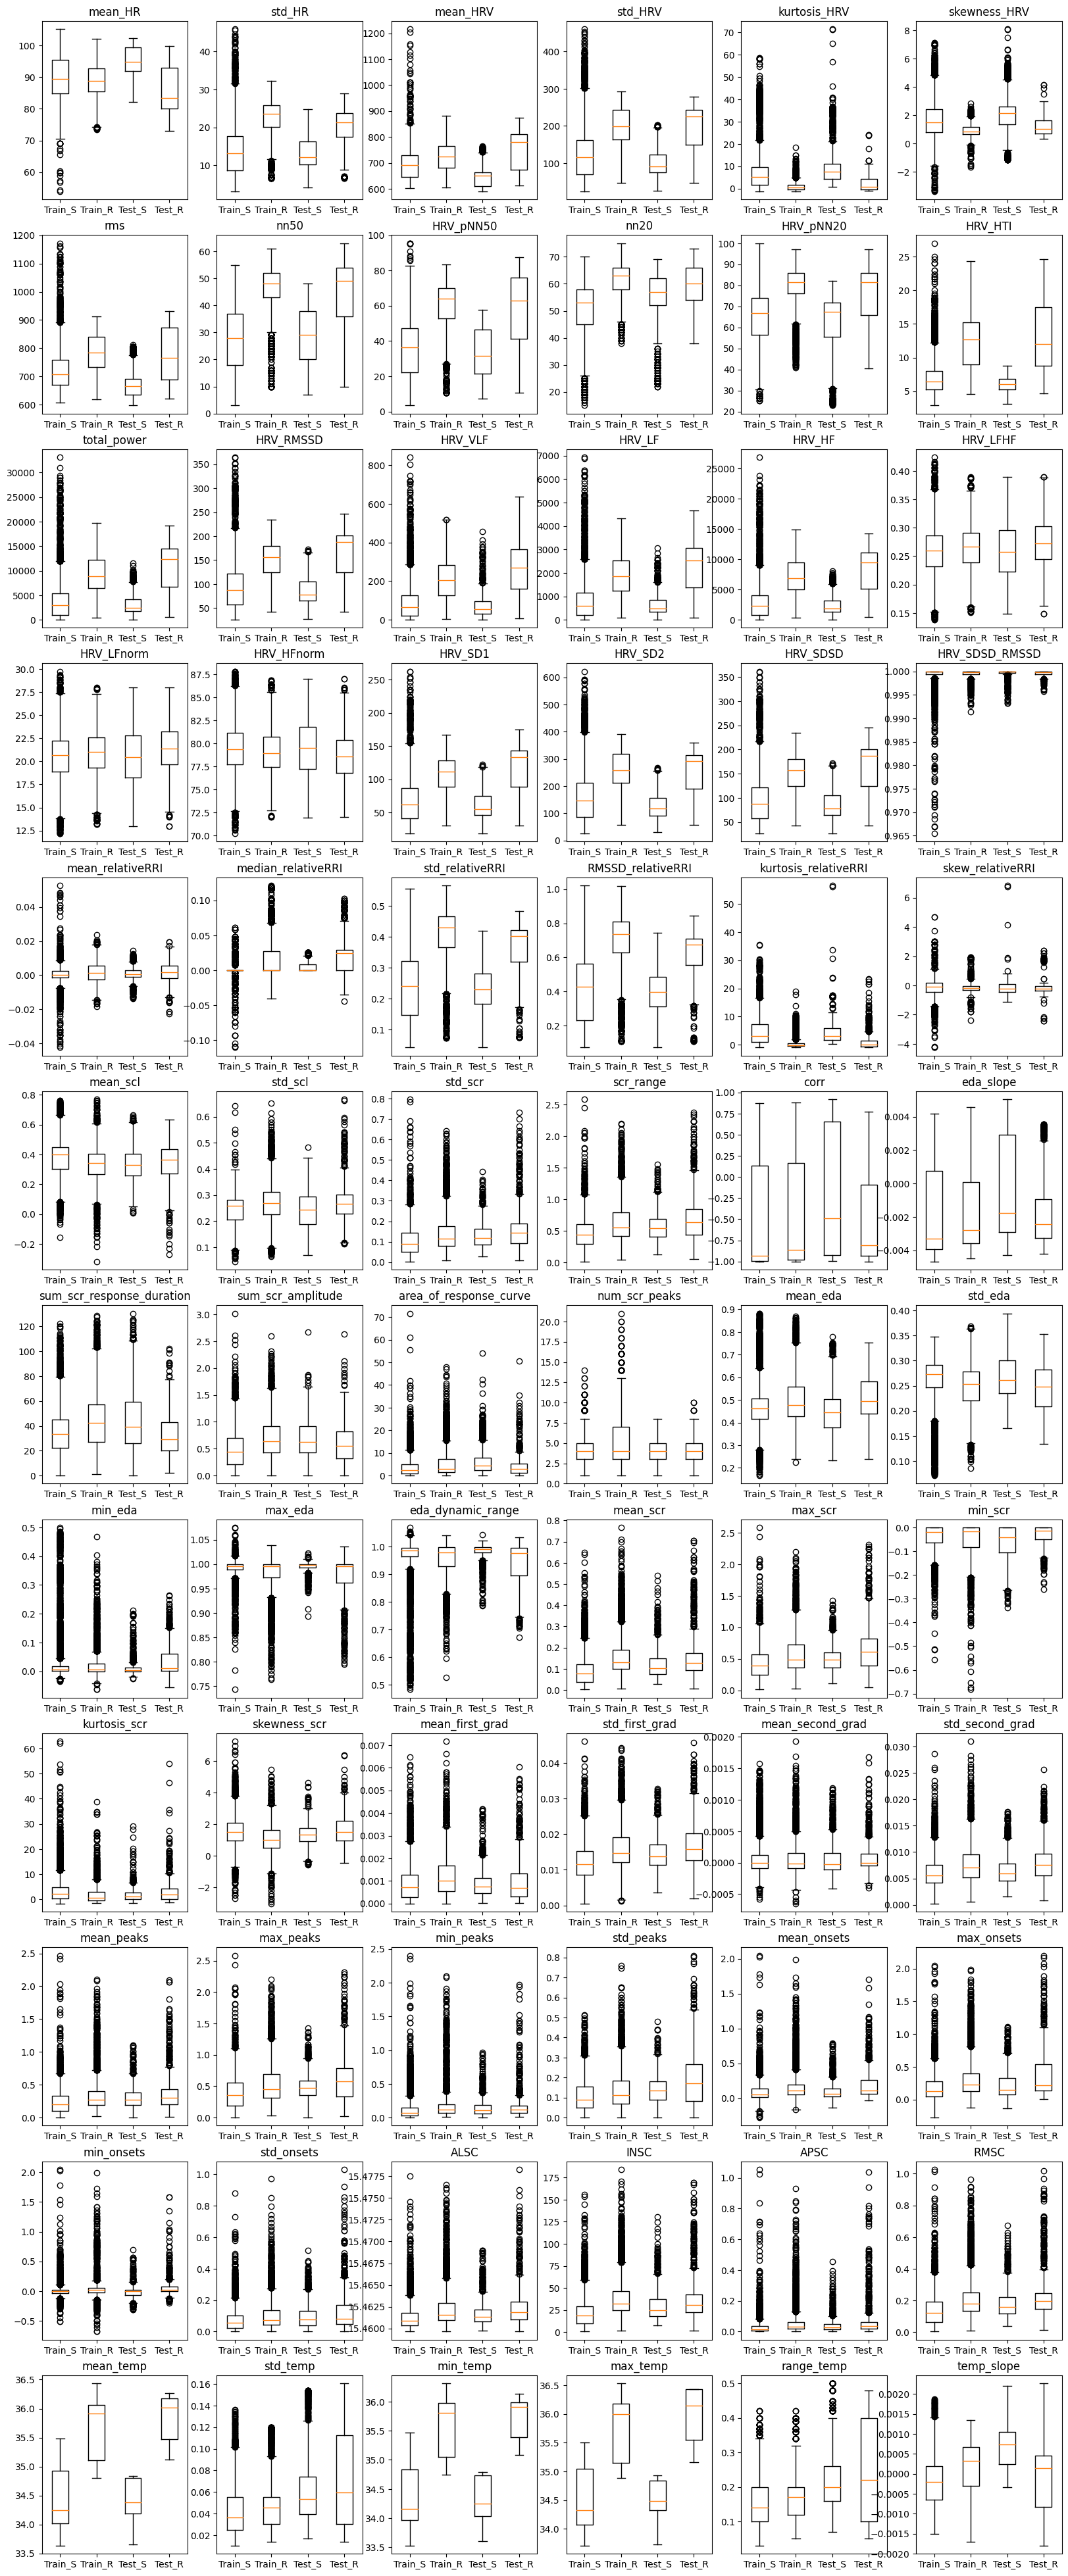

In [10]:
# boxplot_by_features(X_train_stress, X_train_relaxed)
boxplot_by_features(X_train_stress, X_train_relaxed, X_test_stress, X_test_relaxed, labels = ['Train_S', 'Train_R', 'Test_S', 'Test_R'])

In [15]:
clf = ExtraTreesClassifier(
    n_estimators = 500,
    random_state = 0, 
    n_jobs = -1, 
    max_features = 'sqrt', 
    max_depth = 8, 
    min_samples_split = 2, 
    min_samples_leaf = 8,
    oob_score = True, 
    bootstrap = True, 
    class_weight = 'balanced'
)
# clf = LogisticRegression(
#     random_state = 0,
#     class_weight = 'balanced',
#     n_jobs = -1,
#     solver = 'saga',
#     max_iter = 5000,
# )

In [16]:
# Re-train models in the lab for user
scaler = StandardScaler()
scaler.fit(user_data[user_id]['X_train'][:, :66])
clf.fit(scaler.transform(user_data[user_id]['X_train'][:, :66]), user_data[user_id]['y_train'])
y_pred = clf.predict(scaler.transform(user_data[user_id]['X_test'][:, :66]))
Evaluator().evaluate(user_data[user_id]['y_test'], y_pred)

{'accuracy': 0.9981606376456161,
 'balanced_accuracy': 0.9967948717948718,
 'precision': 1.0,
 'recall': 0.9935897435897436,
 'f1': 0.9967845659163987}

In [17]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(user_data[user_id]['X_test'][:, :66])

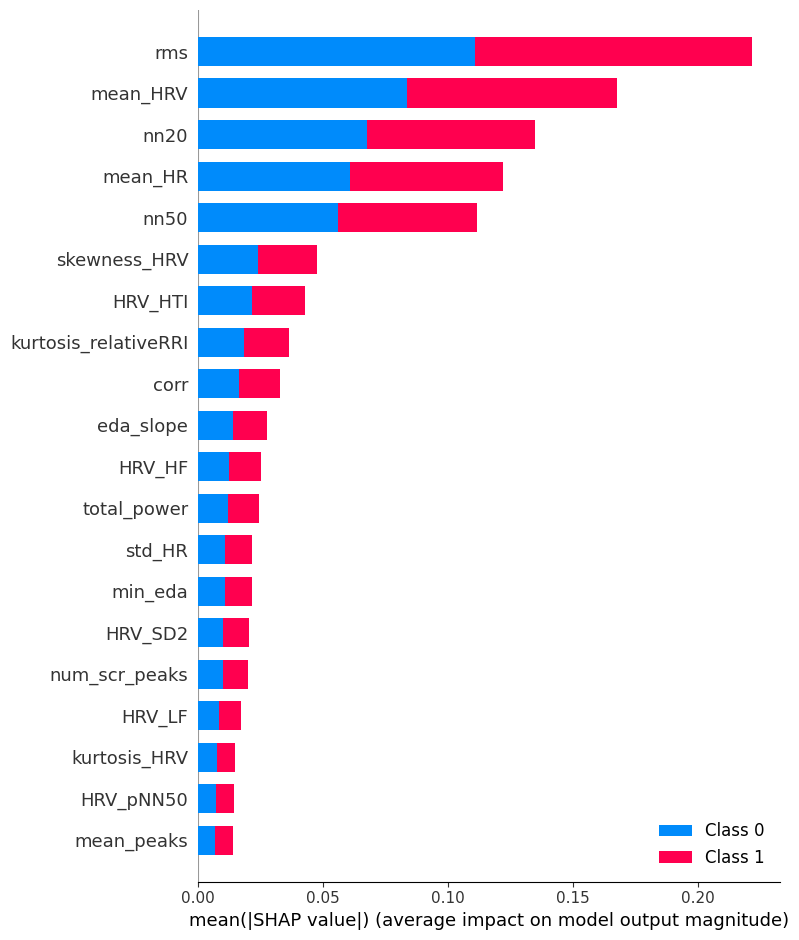

In [18]:
shap.summary_plot(shap_values, user_data[user_id]['X_test'][:, :66], feature_names=feature_names)

# EXPERIMENT DATA

In [11]:
date = '2022-09-12'

In [12]:
itw_datapath_manager = ITWDataPathManager(itw_dataset_name)
feature_folder_path = itw_datapath_manager.get_feature_path_by_date(user_id, date)
# feature_path = os.path.join(feature_folder_path, 'X.npy')
feature_path = os.path.join(feature_folder_path, 'bvp_eda_temp.npy')
ground_truth_path = os.path.join(feature_folder_path, 'y.npy')
# feature_path = os.path.join(feature_folder_path, 'X_moment.npy')
# ground_truth_path = os.path.join(feature_folder_path, 'y_moment.npy')
info_path = os.path.join(feature_folder_path, 'datetime_info.npy')

In [13]:
features = np.nan_to_num(np.load(feature_path))
# ground_truth = np.load(ground_truth_path)
ground_truth = np.zeros(features.shape[0])
# datetime_info = np.load(info_path)

X_test_stress = features[ground_truth == 1]
X_test_relaxed = features[ground_truth == 0]

In [14]:
y_pred = clf.predict(scaler.transform(features[:, :]))
print(Evaluator().evaluate(ground_truth, y_pred))
ConfusionMatrixDisplay.from_predictions(ground_truth, y_pred, display_labels=['Relax', 'Stress'])

NameError: name 'clf' is not defined

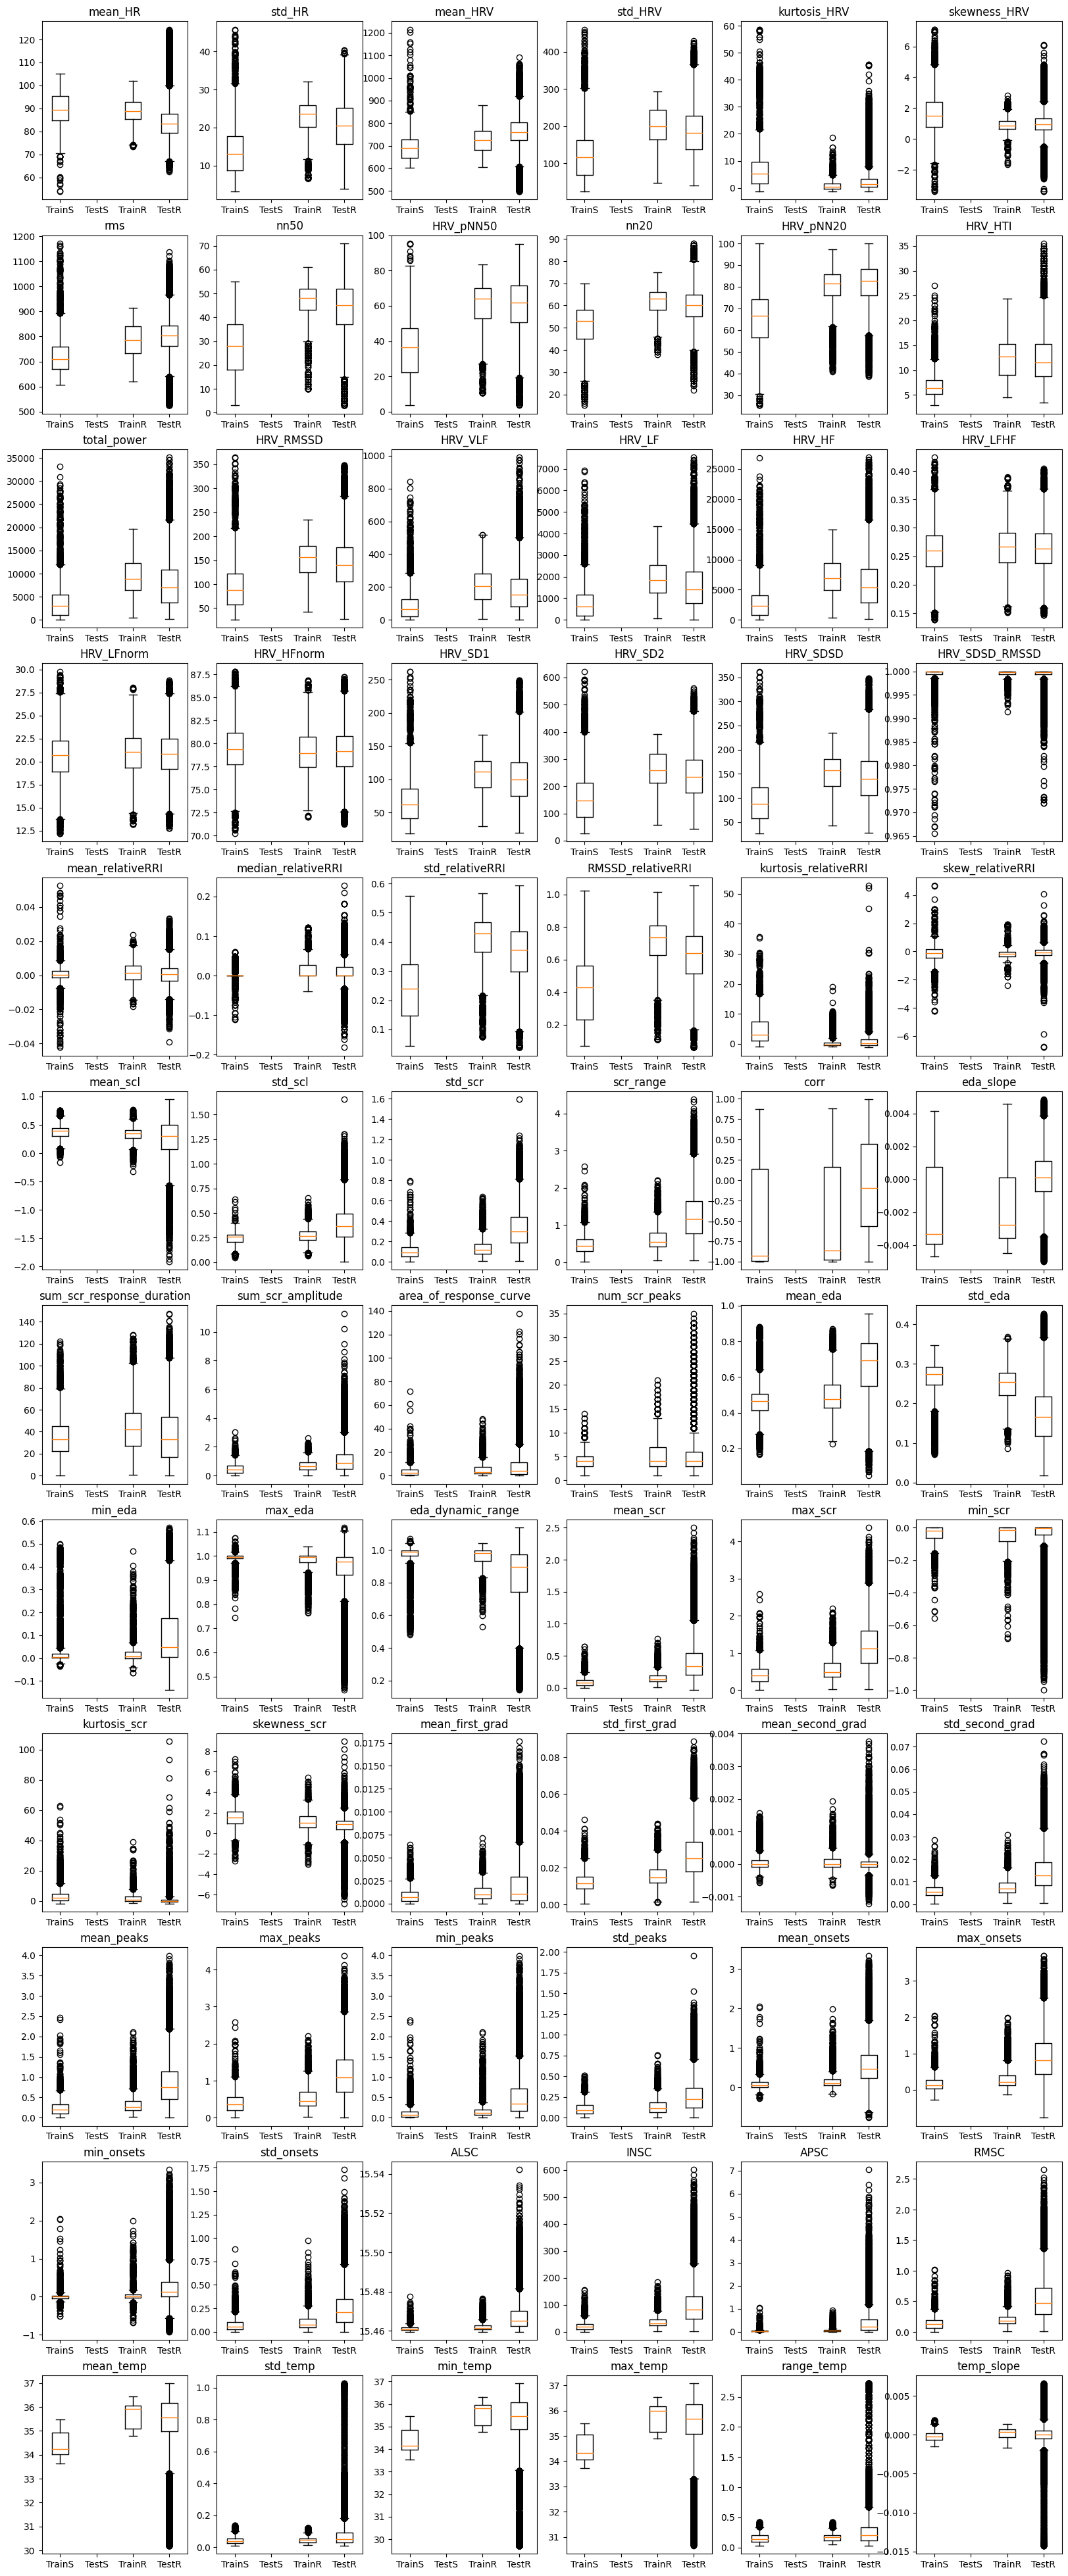

In [15]:
boxplot_by_features(X_train_stress, X_test_stress, X_train_relaxed, X_test_relaxed, labels = ['TrainS', 'TestS', 'TrainR', 'TestR'])
# boxplot_by_features(X_test_stress, X_test_relaxed, labels = ['TestS', 'TestR'])
# boxplot_by_features(X_train_stress, X_train_relaxed)

In [ ]:
shap_values_itw = explainer.shap_values(X_test_stress[:1000, :])

In [ ]:
shap.summary_plot(shap_values_itw, features, feature_names=feature_names)

In [ ]:
clf.fit(features, ground_truth)
y_pred = clf.predict(features)
Evaluator().evaluate(ground_truth, y_pred)

In [ ]:
y_pred = clf.predict(X_train)
Evaluator().evaluate(y_train, y_pred)